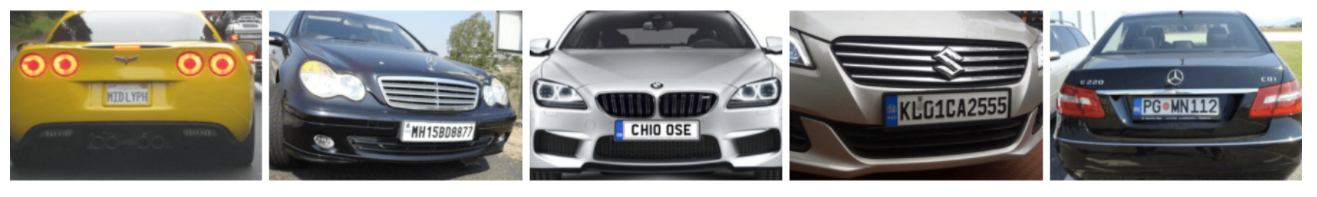

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [28]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/annotations/Cars227.xml
/kaggle/input/car-plate-detection/annotations/Cars145.xml
/kaggle/input/car-

We create the variable X containing all the images of cars by resizing them to 200 * 200.



In [29]:
IMAGE_SIZE = 200

In [30]:
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [31]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [32]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [33]:
resizeannotation("/kaggle/input/car-plate-detection/annotations/Cars147.xml")

[168, 126, 90, 93]

In [34]:
y[0]

[167, 129, 90, 93]

We check X et y shape

In [35]:
np.array(X).shape

(433, 200, 200, 3)

In [36]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

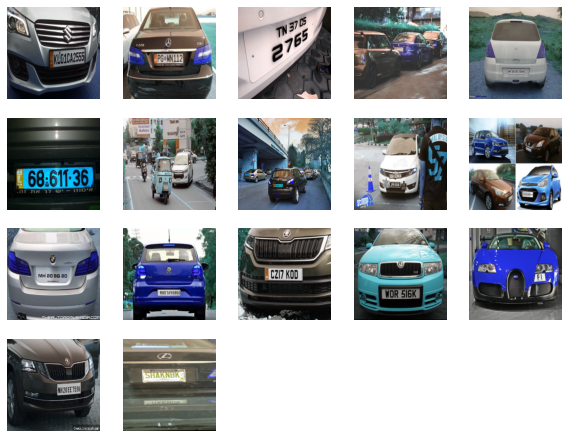

In [37]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

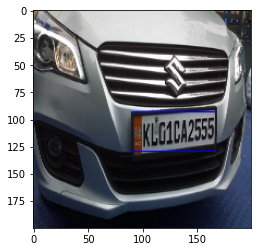

In [38]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


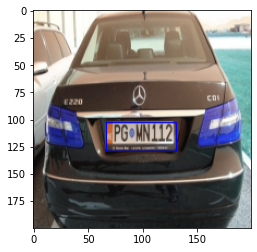

In [39]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [40]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [41]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [43]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

from keras.applications.mobilenet_v2 import MobileNetV2

from keras.applications.resnet50 import ResNet50

In [67]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense
model = Sequential()
model.add(Conv2D(64 , (3,3) , input_shape=(200,200,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Conv2D(32 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 73728)            

In [44]:
# Create the model
model = Sequential()
model.add(ResNet50(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 36,457,924
Trainable params: 12,870,212
Non-trainable params: 23,587,712
_________________________________

In [45]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [47]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
13/13 [==============================] - 1s 58ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 2/50
13/13 [==============================] - 1s 54ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 3/50
13/13 [==============================] - 1s 54ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 4/50
13/13 [==============================] - 1s 53ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 5/50
13/13 [==============================] - 1s 53ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 6/50
13/13 [==============================] - 1s 53ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 7/50
13/13 [==============================] - 1s 54ms/step - loss: 0.2380 - accuracy: 0.4704 - val_loss: 0.2273 - val_accuracy: 0.4091
Epoch 8/50
13

In [49]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 40.91%


In [50]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

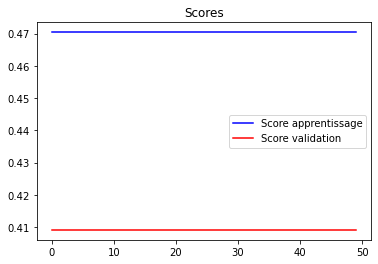

In [51]:
plot_scores(train)

## DETECTION 

In [52]:
 y_cnn = model.predict(X_test)

In [53]:
y_cnn.shape

(44, 4)

We can see how our model localize license plates on our testing set :

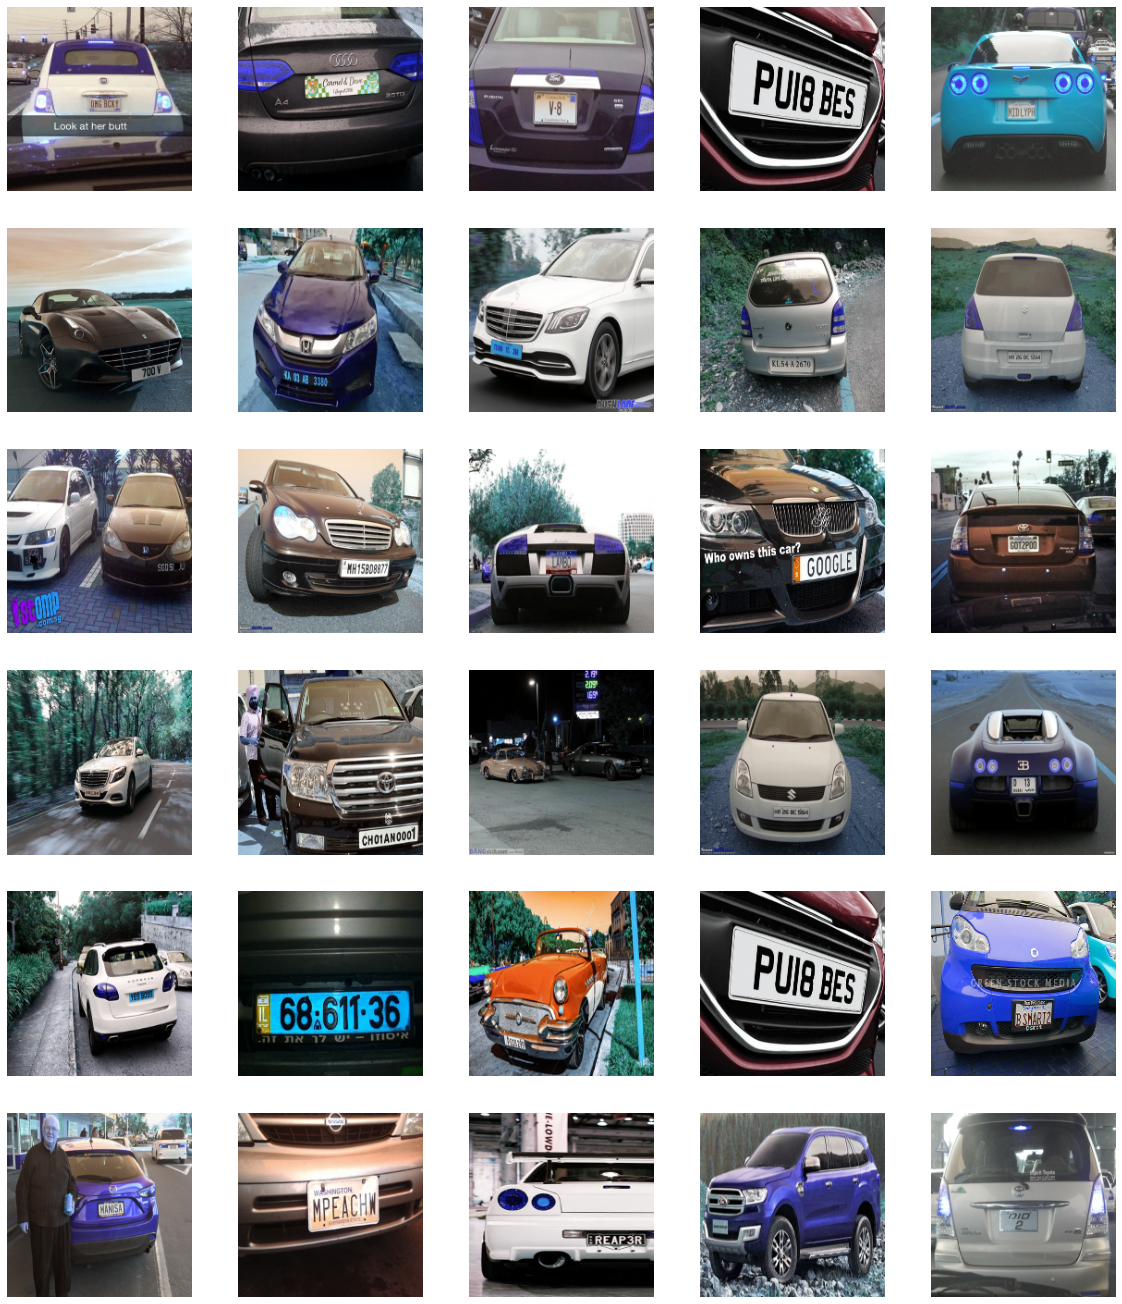

In [54]:
plt.figure(figsize=(20,40))
for i in range(0,30) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

